In [1]:
import argparse
import os
import numpy as np
import pickle
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms as T
from model.pspnet import PSPNet
from datasets import get_data_detail

# 1. Settings

In [2]:
parser = argparse.ArgumentParser()
# Model settings
parser.add_argument('--shrink_image', type=list, default=[400, 600])
# Settings need to be tuned
parser.add_argument('--backbone', type=str, default='resnet18')  # Num of cross validation folds
parser.add_argument('--data', default='assd')
parser.add_argument('--bin_sizes', type=list, default=[1, 2, 3, 6])
parser.add_argument('--enable_aux', type=bool, default=True)
parser.add_argument('--alpha_loss', type=float, default=0.2)
parser.add_argument('--backbone_freeze', type=bool, default=True)
parser.add_argument('--name_mode_dict', default='demo.pkl')

opt, unknown = parser.parse_known_args()
opt.device = torch.device('cuda')
opt.seg_criterion = torch.nn.CrossEntropyLoss().to(opt.device)

(opt.num_label, opt.h, opt.w) = get_data_detail(opt.data)
if opt.backbone == 'resnet18':
    opt.out_dim_resnet = 512
    opt.out_dim_resnet_auxiliary = 256
    opt.out_dim_pooling = 512
elif opt.backbone == 'resnet34':
    opt.out_dim_resnet = 512
    opt.out_dim_resnet_auxiliary = 256
    opt.out_dim_pooling = 512
elif opt.backbone == 'resnet50':
    opt.out_dim_resnet = 2048
    opt.out_dim_resnet_auxiliary = 1024
    opt.out_dim_pooling = 2048
else:
    raise RuntimeError('\n[warning] Wrong demo settings.\n')

# 2. Preprocess & Augmentation

In [3]:
mean = np.array([0.44619015, 0.44376444, 0.40185362])
std = np.array([0.20309216, 0.19916435, 0.209552])

to_tensor = T.Compose([
    T.ToTensor(),
])

normalize = T.Compose([
    T.Normalize(mean=mean, std=std),
])

normalize = T.Compose([
    T.Normalize(mean=mean, std=std),
])

shrink = T.Compose([
    T.Resize(opt.shrink_image, T.InterpolationMode.NEAREST),
    # T.ConvertImageDtype(torch.float),
])

h_flip = T.RandomHorizontalFlip(p=1.0)
v_flip = T.RandomVerticalFlip(p=1.0)

to_image = T.Compose([
    T.ToPILImage(),
])

In [4]:
def display(display_list, id, loss):
    plt.figure(figsize=(20, 30))

    title = ['Input Image', 'True Mask', 'Predicted Mask']
    loss_title = ['Loss', 'mIoU', 'PA']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i] + ': No.' + id + ' & '+ loss_title[i] +': ' + str(loss[i]))
        plt.axis('off')
        plt.imshow(to_image(display_list[i]))
    plt.show()

In [5]:
def get_metrics(y_score, y_gt, num_label):
    """
    Compute mean IoU and per pixel accuracy.
    """
    y_pred = y_score.argmax(1).unsqueeze(1)
    pa = y_pred.eq(y_gt).sum() / y_gt.numel()

    iou = torch.zeros(num_label).to(y_gt.device)
    for i in range(num_label):
        pred_i = y_pred == i
        gt_i = y_gt == i
        intersect = (pred_i & gt_i).sum()
        union = pred_i.sum() + gt_i.sum() - intersect
        if union == 0:
            union = 1e9
        iou[i] = intersect / union

    return iou.mean(), pa

# 3. Visualization

In [6]:
with open('_result/model/'+opt.name_mode_dict, 'rb') as f:
    dict_demo = pickle.load(f)
model = PSPNet(opt)        
model.load_state_dict(dict_demo)
model = model.to(opt.device)

test_id = ['161', '533', '425', '309', '276']

# 4. Test augment

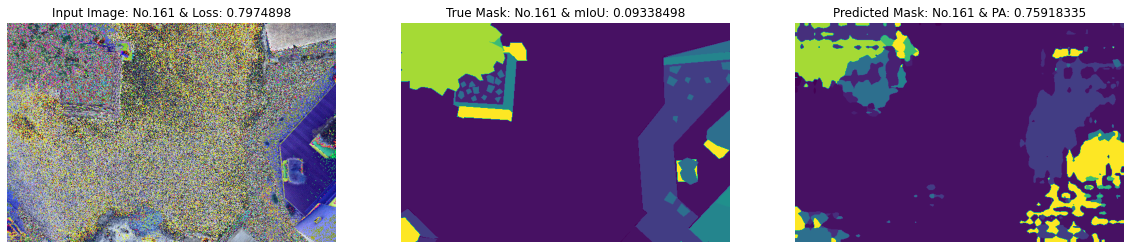

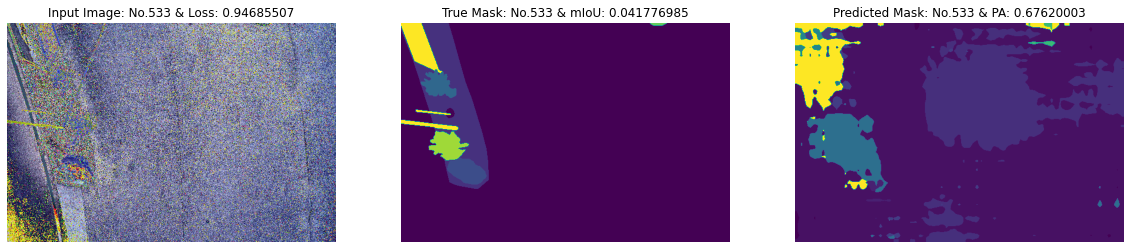

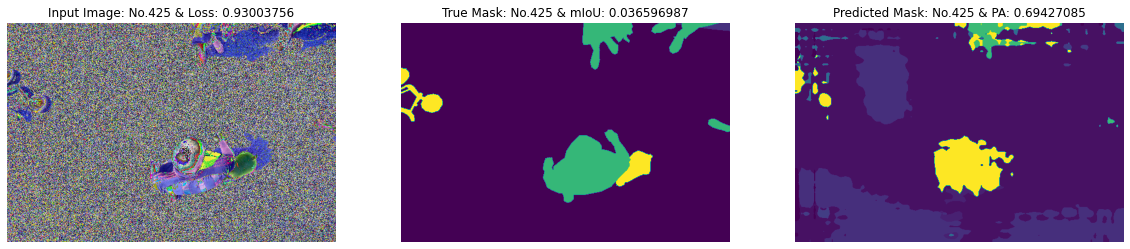

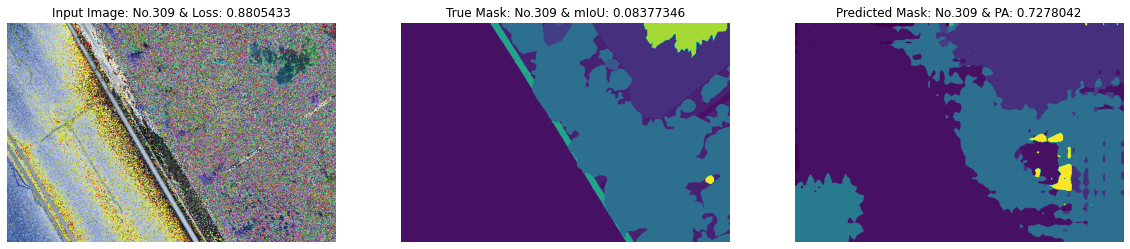

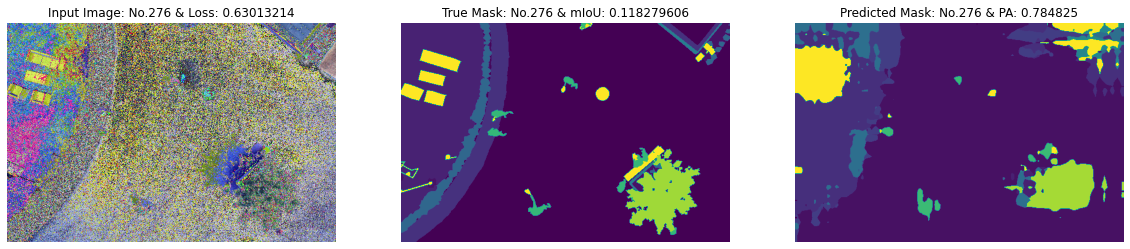

In [8]:
for id in test_id:
    id_list = []
    
    path_img = '_data/assd/original_images/' + id + '.jpg'
    path_gt = '_data/assd/label_images_semantic/' + id + '.png'
    
    img = to_tensor(np.array(Image.open(path_img))).to(opt.device)
    gt = to_tensor(np.array(Image.open(path_gt))).to(opt.device) * 255
    
    p=0.7
    cropper = T.RandomCrop(size=(int(4000*p), int(6000*p)))
    
    img_gt = cropper(torch.cat((img, gt), 0))
    img_crop, gt_crop = img_gt[:3, :, :], img_gt[3, :, :].unsqueeze(0).long()
    
    img_small = normalize(shrink(img_crop))
    gt_small = shrink(gt_crop)
    

    id_list.append(img_small)
    id_list.append(gt_small/255)
    
    with torch.no_grad():
        x = img_small.unsqueeze(0)
        y_score, _ = model(x)
        loss = opt.seg_criterion(y_score, gt_small)
        
    y_pred = y_score.argmax(1) / 255
    id_list.append(y_pred)
    
    miou, pa = get_metrics(y_score, gt_small, opt.num_label)
    
    
    display(id_list, id, [loss.cpu().numpy(), miou.cpu().numpy(), pa.cpu().numpy()])